In [84]:
import pandas as pd

In [85]:
import pandas as pd
import numpy as np

DATA_DIR = "data"   # change if needed

# To avoid memory issues, optionally limit how many training rows we load
N_TRAIN = 200_000   # or None for full data

pd.options.display.max_columns = 100


In [86]:
events = pd.read_csv(f"{DATA_DIR}/events.csv")
clicks_train = pd.read_csv(
    f"{DATA_DIR}/clicks_train.csv",
    nrows=N_TRAIN
)
promoted = pd.read_csv(f"{DATA_DIR}/promoted_content.csv")
doc_meta = pd.read_csv(f"{DATA_DIR}/documents_meta.csv")
doc_topics = pd.read_csv(f"{DATA_DIR}/documents_topics.csv")

C:\Users\Rahm\AppData\Local\Temp\ipykernel_23372\1881965447.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv(f"{DATA_DIR}/events.csv")


In [87]:
print(events.head())
print(clicks_train.head())
print(promoted.head())
print(doc_meta.head())
print(doc_topics.head())


   display_id            uuid  document_id  timestamp platform geo_location
0           1  cb8c55702adb93       379743         61        3    US>SC>519
1           2  79a85fa78311b9      1794259         81        2    US>CA>807
2           3  822932ce3d8757      1179111        182        2    US>MI>505
3           4  85281d0a49f7ac      1777797        234        2    US>WV>564
4           5  8d0daef4bf5b56       252458        338        2        SG>00
   display_id   ad_id  clicked
0           1   42337        0
1           1  139684        0
2           1  144739        1
3           1  156824        0
4           1  279295        0
   ad_id  document_id  campaign_id  advertiser_id
0      1         6614            1              7
1      2       471467            2              7
2      3         7692            3              7
3      4       471471            2              7
4      5       471472            2              7
   document_id  source_id  publisher_id         publish_ti

In [88]:
events_small = events.copy()

# rename for clarity
events_small = events_small.rename(columns={
    "document_id": "event_doc_id",
    "timestamp": "event_timestamp"
})

# split geo_location into country / region / dma
geo_split = events_small["geo_location"].str.split(">", expand=True)
events_small["country"] = geo_split[0]
events_small["region"] = geo_split[1]
events_small["dma"] = geo_split[2]

# simple time feature: "event_hour" from seconds since start
events_small["event_hour"] = (events_small["event_timestamp"] // 3600).astype("int16")

events_small = events_small.drop(columns=["geo_location"])
events_small.head()

,display_id,uuid,event_doc_id,event_timestamp,platform,country,region,dma,event_hour
0,1,cb8c55702adb93,379743,61,3,US,SC,519,0
1,2,79a85fa78311b9,1794259,81,2,US,CA,807,0
2,3,822932ce3d8757,1179111,182,2,US,MI,505,0
3,4,85281d0a49f7ac,1777797,234,2,US,WV,564,0
4,5,8d0daef4bf5b56,252458,338,2,SG,00,None,0


In [89]:
promoted_small = promoted.rename(columns={
    "document_id": "ad_doc_id"
})
promoted_small.head()

,ad_id,ad_doc_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7


In [90]:
# sort by confidence descending so first per document is top topic
doc_topics_sorted = doc_topics.sort_values(
    ["document_id", "confidence_level"],
    ascending=[True, False]
)

# keep top row per document
doc_topics_top = doc_topics_sorted.drop_duplicates("document_id", keep="first")

doc_topics_top = doc_topics_top.rename(columns={
    "document_id": "doc_id",
    "topic_id": "top_topic_id",
    "confidence_level": "top_topic_conf"
})

doc_topics_top.head()


,doc_id,top_topic_id,top_topic_conf
4504005,1,252,0.020726
937048,2,216,0.013029
164161,3,276,0.029914
4996667,4,102,0.084171
4996673,5,75,0.106555


In [91]:
doc_meta_small = doc_meta.rename(columns={"document_id": "doc_id"})
doc_meta_small.head()

,doc_id,source_id,publisher_id,publish_time
0,1595802,1.0,603.0,2016-06-05 00:00:00
1,1524246,1.0,603.0,2016-05-26 11:00:00
2,1617787,1.0,603.0,2016-05-27 00:00:00
3,1615583,1.0,603.0,2016-06-07 00:00:00
4,1615460,1.0,603.0,2016-06-20 00:00:00


In [92]:
# 1) clicks + events (on display_id)
train = clicks_train.merge(
    events_small,
    on="display_id",
    how="left"
)

# 2) then add ad metadata (on ad_id)
train = train.merge(
    promoted_small,
    on="ad_id",
    how="left"
)

train.head()
print(train.shape)


(200000, 14)


In [93]:
# event document: join meta
train = train.merge(
    doc_meta_small.add_prefix("event_doc_"),
    left_on="event_doc_id",
    right_on="event_doc_doc_id",
    how="left"
)

# event document: join top topic
train = train.merge(
    doc_topics_top.add_prefix("event_doc_"),
    left_on="event_doc_id",
    right_on="event_doc_doc_id",
    how="left"
)


In [94]:
# ad document: join meta
train = train.merge(
    doc_meta_small.add_prefix("ad_doc_"),
    left_on="ad_doc_id",
    right_on="ad_doc_doc_id",
    how="left"
)

# ad document: join top topic
train = train.merge(
    doc_topics_top.add_prefix("ad_doc_"),
    left_on="ad_doc_id",
    right_on="ad_doc_doc_id",
    how="left"
)


In [95]:
cols_to_drop = [c for c in train.columns if c.endswith("_doc_doc_id")]
train = train.drop(columns=cols_to_drop)

train.head()
train.shape


(200000, 28)

In [96]:
train.to_csv(f"{DATA_DIR}/train_merged.csv", index=False)

In [97]:
train["event_dayofweek"] = (train["event_timestamp"] // (3600*24)) % 7
train["event_part_of_day"] = pd.cut(
    train["event_hour"],
    bins=[0,6,12,18,24],
    labels=["night","morning","afternoon","evening"],
    include_lowest=True
)


In [98]:
train

,display_id,ad_id,clicked,uuid,event_doc_id,event_timestamp,platform,country,region,dma,event_hour,ad_doc_id,campaign_id,advertiser_id,event_doc_doc_id_x,event_doc_source_id,event_doc_publisher_id,event_doc_publish_time,event_doc_doc_id_y,event_doc_top_topic_id,event_doc_top_topic_conf,ad_doc_doc_id_x,ad_doc_source_id,ad_doc_publisher_id,ad_doc_publish_time,ad_doc_doc_id_y,ad_doc_top_topic_id,ad_doc_top_topic_conf,event_dayofweek,event_part_of_day
0,1,42337,0,cb8c55702adb93,379743,61,3,US,SC,519,0,938164,5969,1499,379743,6482.0,24.0,NaN,379743.0,285.0,0.020254,938164,5802.0,NaN,2016-07-27 00:00:00,938164.0,142.0,0.311555,0,night
1,1,139684,0,cb8c55702adb93,379743,61,3,US,SC,519,0,1085937,17527,2563,379743,6482.0,24.0,NaN,379743.0,285.0,0.020254,1085937,10727.0,NaN,2016-02-09 15:00:00,1085937.0,231.0,0.363159,0,night
2,1,144739,1,cb8c55702adb93,379743,61,3,US,SC,519,0,1337362,18488,2909,379743,6482.0,24.0,NaN,379743.0,285.0,0.020254,1337362,11328.0,NaN,2016-04-24 08:00:00,1337362.0,131.0,0.272269,0,night
3,1,156824,0,cb8c55702adb93,379743,61,3,US,SC,519,0,992370,7283,1919,379743,6482.0,24.0,NaN,379743.0,285.0,0.020254,992370,8064.0,NaN,2015-07-24 00:00:00,992370.0,138.0,0.318320,0,night
4,1,279295,0,cb8c55702adb93,379743,61,3,US,SC,519,0,1670176,27524,1820,379743,6482.0,24.0,NaN,379743.0,285.0,0.020254,1670176,8239.0,NaN,2016-06-02 03:00:00,1670176.0,16.0,0.045296,0,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,39083,219445,0,90b3318708d0cb,1737555,2946638,3,DE,02,None,818,1553251,24649,1679,1737555,4942.0,180.0,2016-06-12 09:00:00,1737555.0,131.0,0.036142,1553251,7904.0,NaN,NaN,1553251.0,25.0,0.077869,6,NaN
199996,39084,33731,0,1f7bf746c18096,394689,2946665,1,US,NM,790,818,469489,4926,172,394689,7343.0,874.0,NaN,394689.0,147.0,0.015912,469489,3678.0,NaN,2015-01-02 00:00:00,469489.0,142.0,0.410036,6,NaN
199997,39084,329944,0,1f7bf746c18096,394689,2946665,1,US,NM,790,818,1764355,29250,4021,394689,7343.0,874.0,NaN,394689.0,147.0,0.015912,1764355,13004.0,NaN,NaN,1764355.0,296.0,0.103346,6,NaN
199998,39084,330189,1,1f7bf746c18096,394689,2946665,1,US,NM,790,818,1765521,29255,4022,394689,7343.0,874.0,NaN,394689.0,147.0,0.015912,1765521,11074.0,NaN,2015-10-13 00:00:00,1765521.0,296.0,0.041069,6,NaN


In [99]:
# 1. Check dtypes (just to see)
print(train[["event_timestamp", "event_doc_publish_time", "ad_doc_publish_time"]].dtypes)

event_timestamp            int64
event_doc_publish_time    object
ad_doc_publish_time       object
dtype: object


In [100]:
# 2. Make sure event_timestamp is numeric
train["event_timestamp"] = pd.to_numeric(train["event_timestamp"], errors="coerce")

# 3. Convert publish times to proper datetimes
train["event_doc_publish_time"] = pd.to_datetime(
    train["event_doc_publish_time"], errors="coerce"
)
train["ad_doc_publish_time"] = pd.to_datetime(
    train["ad_doc_publish_time"], errors="coerce"
)


In [101]:
import pandas as pd

BASE_TIME = pd.Timestamp("2016-06-01")

train["event_time_dt"] = BASE_TIME + pd.to_timedelta(
    train["event_timestamp"], unit="s"
)

In [102]:
# event page age in hours at the time of impression
train["event_doc_age_hours"] = (
    train["event_time_dt"] - train["event_doc_publish_time"]
).dt.total_seconds() / 3600.0

# ad doc age in hours
train["ad_doc_age_hours"] = (
    train["event_time_dt"] - train["ad_doc_publish_time"]
).dt.total_seconds() / 3600.0

# optionally clip or fill NaNs
train["event_doc_age_hours"] = train["event_doc_age_hours"].fillna(0)
train["ad_doc_age_hours"] = train["ad_doc_age_hours"].fillna(0)


In [103]:
train[["event_time_dt", "event_doc_publish_time", "event_doc_age_hours"]].head()

,event_time_dt,event_doc_publish_time,event_doc_age_hours
0,2016-06-01 00:01:01,NaT,0.0
1,2016-06-01 00:01:01,NaT,0.0
2,2016-06-01 00:01:01,NaT,0.0
3,2016-06-01 00:01:01,NaT,0.0
4,2016-06-01 00:01:01,NaT,0.0


In [104]:
train[["event_time_dt", "ad_doc_publish_time", "ad_doc_age_hours"]].head()

,event_time_dt,ad_doc_publish_time,ad_doc_age_hours
0,2016-06-01 00:01:01,2016-07-27 00:00:00,-1343.983056
1,2016-06-01 00:01:01,2016-02-09 15:00:00,2697.016944
2,2016-06-01 00:01:01,2016-04-24 08:00:00,904.016944
3,2016-06-01 00:01:01,2015-07-24 00:00:00,7512.016944
4,2016-06-01 00:01:01,2016-06-02 03:00:00,-26.983056


In [105]:
# recompute hour and add day-of-week from datetime
train["event_hour"] = train["event_time_dt"].dt.hour.astype("int8")
train["event_dayofweek"] = train["event_time_dt"].dt.dayofweek.astype("int8")

# part of day (categorical)
train["event_part_of_day"] = pd.cut(
    train["event_hour"],
    bins=[-1, 5, 11, 17, 23],
    labels=["night", "morning", "afternoon", "evening"]
)

# fill geo nulls
for col in ["country", "region", "dma"]:
    train[col] = train[col].fillna("UNK")


In [106]:
# user impression count
train["user_impressions"] = train.groupby("uuid")["display_id"].transform("count").astype("int32")

# ad impression count
train["ad_impressions"] = train.groupby("ad_id")["display_id"].transform("count").astype("int32")

# campaign impression count
train["campaign_impressions"] = train.groupby("campaign_id")["display_id"].transform("count").astype("int32")

# publisher impression count (based on event document publisher)
train["publisher_impressions"] = train.groupby("event_doc_publisher_id")["display_id"].transform("count").astype("int32")


In [107]:
global_ctr = train["clicked"].mean()

# ad CTR
train["ad_ctr"] = train.groupby("ad_id")["clicked"].transform("mean")

# campaign CTR
train["campaign_ctr"] = train.groupby("campaign_id")["clicked"].transform("mean")

# publisher CTR (event-side publisher)
train["publisher_ctr"] = train.groupby("event_doc_publisher_id")["clicked"].transform("mean")

# fill missing CTRs with global mean
for col in ["ad_ctr", "campaign_ctr", "publisher_ctr"]:
    train[col] = train[col].fillna(global_ctr).astype("float32")


In [108]:
train["same_topic"] = (
    train["event_doc_top_topic_id"] == train["ad_doc_top_topic_id"]
).astype("int8")


In [109]:
drop_cols = [
    "display_id",
    "uuid",
    "event_timestamp",
    "event_time_dt",
    "event_doc_publish_time",
    "ad_doc_publish_time",
    "event_doc_id",
    "ad_doc_id"
]

# defensive: drop any join-helper cols if still around
drop_cols += [c for c in train.columns if c.endswith("_doc_doc_id")]

train = train.drop(columns=[c for c in drop_cols if c in train.columns])


In [110]:
categorical_cols = [
    "platform",
    "country",
    "region",
    "dma",
    "ad_id",
    "campaign_id",
    "advertiser_id",
    "event_doc_publisher_id",
    "event_doc_source_id",
    "ad_doc_publisher_id",
    "ad_doc_source_id",
    "event_doc_top_topic_id",
    "ad_doc_top_topic_id",
    "event_part_of_day"
]

numeric_cols = [
    "event_hour",
    "event_dayofweek",
    "event_doc_age_hours",
    "ad_doc_age_hours",
    "user_impressions",
    "ad_impressions",
    "campaign_impressions",
    "publisher_impressions",
    "ad_ctr",
    "campaign_ctr",
    "publisher_ctr",
    "same_topic"
]


In [111]:
feature_cols = categorical_cols + numeric_cols

X = train[feature_cols].copy()
y = train["clicked"].astype("int8")

In [112]:
for col in categorical_cols:
    if col in X.columns:
        X[col] = X[col].astype("category")


In [113]:
X

,platform,country,region,dma,ad_id,campaign_id,advertiser_id,event_doc_publisher_id,event_doc_source_id,ad_doc_publisher_id,ad_doc_source_id,event_doc_top_topic_id,ad_doc_top_topic_id,event_part_of_day,event_hour,event_dayofweek,event_doc_age_hours,ad_doc_age_hours,user_impressions,ad_impressions,campaign_impressions,publisher_impressions,ad_ctr,campaign_ctr,publisher_ctr,same_topic
0,3,US,SC,519,42337,5969,1499,24.0,6482.0,NaN,5802.0,285.0,142.0,night,0,2,0.000000,-1343.983056,6,5,5,1233,0.200000,0.200000,0.214112,0
1,3,US,SC,519,139684,17527,2563,24.0,6482.0,NaN,10727.0,285.0,231.0,night,0,2,0.000000,2697.016944,6,5,15,1233,0.000000,0.000000,0.214112,0
2,3,US,SC,519,144739,18488,2909,24.0,6482.0,NaN,11328.0,285.0,131.0,night,0,2,0.000000,904.016944,6,203,388,1233,0.300493,0.286082,0.214112,0
3,3,US,SC,519,156824,7283,1919,24.0,6482.0,NaN,8064.0,285.0,138.0,night,0,2,0.000000,7512.016944,6,178,1243,1233,0.050562,0.028962,0.214112,0
4,3,US,SC,519,279295,27524,1820,24.0,6482.0,NaN,8239.0,285.0,16.0,night,0,2,0.000000,-26.983056,6,13,16,1233,0.230769,0.250000,0.214112,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3,DE,02,UNK,219445,24649,1679,180.0,4942.0,NaN,7904.0,131.0,25.0,night,2,1,545.510556,0.000000,6,15,16,4128,0.200000,0.187500,0.160126,0
199996,1,US,NM,790,33731,4926,172,874.0,7343.0,NaN,3678.0,147.0,142.0,night,2,1,0.000000,13202.518056,3,1,2,6531,0.000000,0.000000,0.143776,0
199997,1,US,NM,790,329944,29250,4021,874.0,7343.0,NaN,13004.0,147.0,296.0,night,2,1,0.000000,0.000000,3,143,143,6531,0.181818,0.181818,0.143776,0
199998,1,US,NM,790,330189,29255,4022,874.0,7343.0,NaN,11074.0,147.0,296.0,night,2,1,0.000000,6386.518056,3,300,300,6531,0.096667,0.096667,0.143776,0


In [114]:
y

0         0
1         0
2         1
3         0
4         0
         ..
199995    0
199996    0
199997    0
199998    1
199999    0
Name: clicked, Length: 200000, dtype: int8

In [115]:
y[y == 0].count()

np.int64(160916)

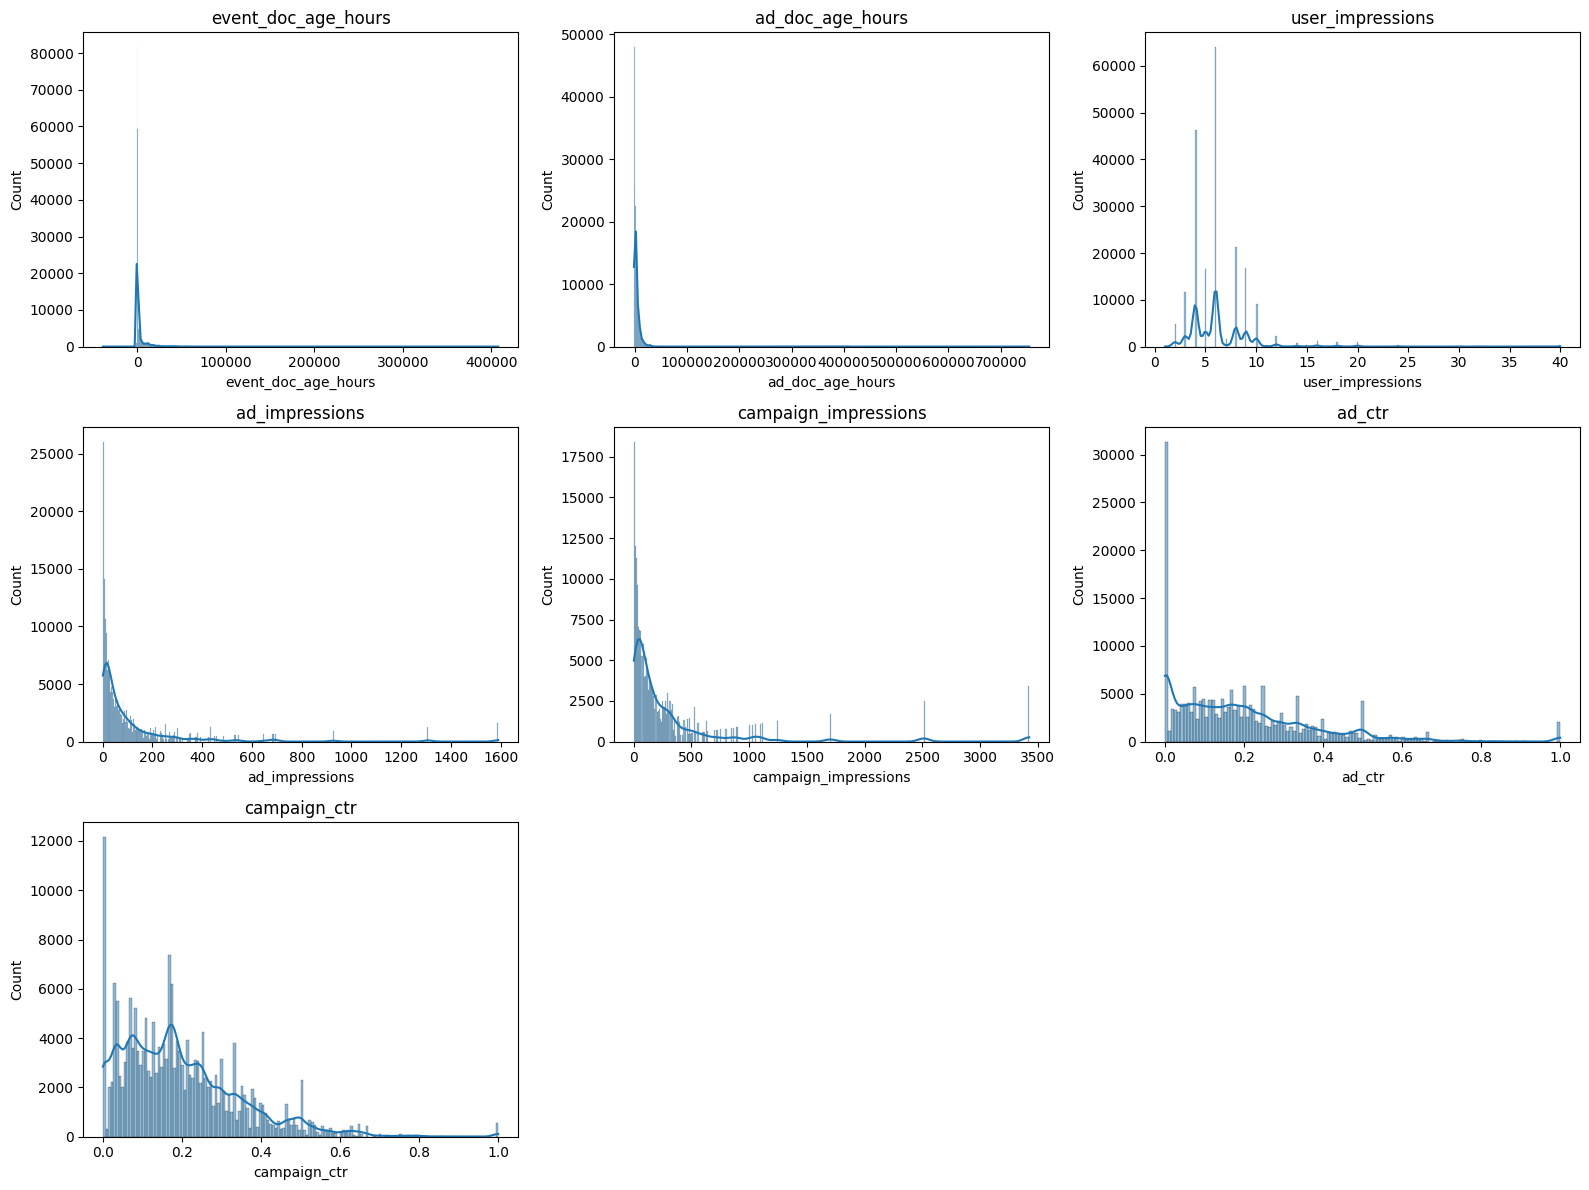

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = [
    "event_doc_age_hours", "ad_doc_age_hours",
    "user_impressions", "ad_impressions", "campaign_impressions",
    "ad_ctr", "campaign_ctr"
]

plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train[col].dropna(), kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()


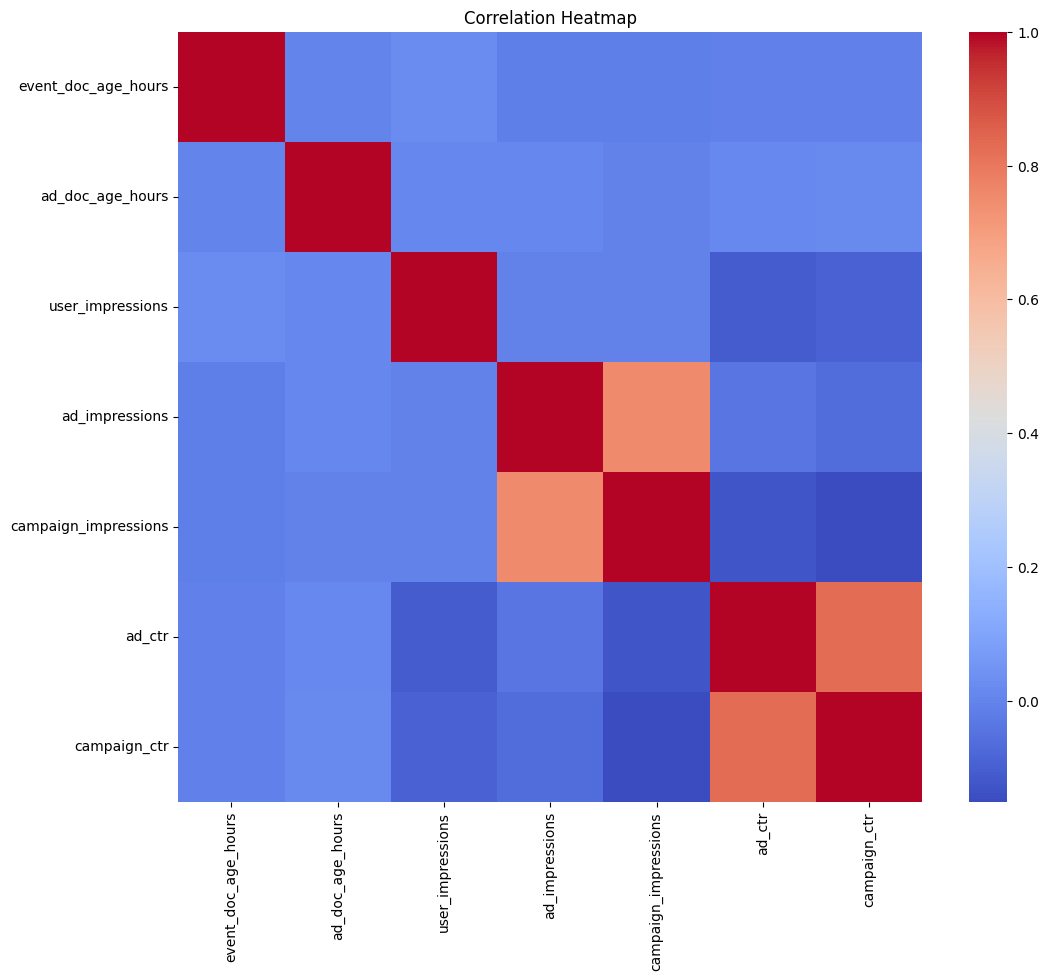

In [117]:
plt.figure(figsize=(12, 10))
sns.heatmap(train[numeric_cols].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

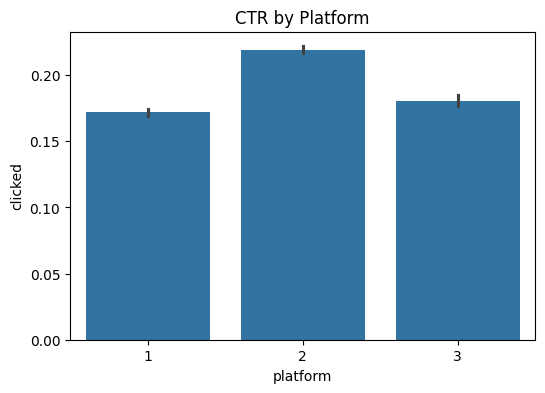

In [118]:
plt.figure(figsize=(6,4))
sns.barplot(x="platform", y="clicked", data=train)
plt.title("CTR by Platform")
plt.show()

In [119]:
# Count distribution
country_counts = train["country"].value_counts()

# Define threshold
THRESHOLD = 200
rare_countries = country_counts[country_counts < THRESHOLD].index
train["country_grouped"] = train["country"].replace(rare_countries, "OTHER")


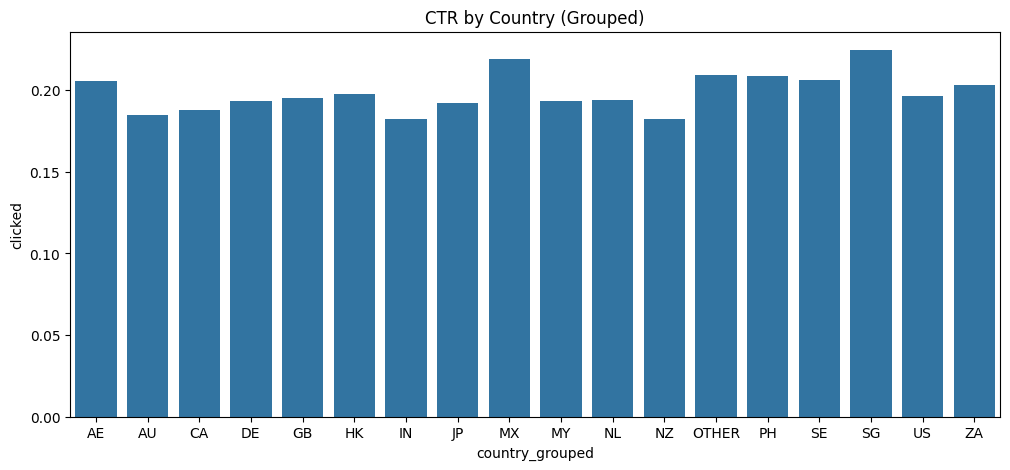

In [120]:
ctr_country2 = train.groupby("country_grouped")["clicked"].mean().reset_index()

plt.figure(figsize=(12,5))
sns.barplot(x="country_grouped", y="clicked", data=ctr_country2)
plt.title("CTR by Country (Grouped)")
plt.show()

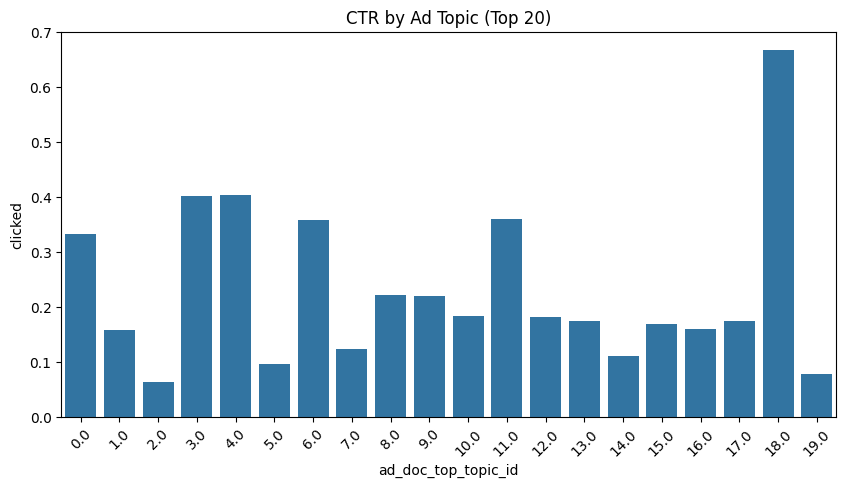

In [121]:
ctr_topic = train.groupby("ad_doc_top_topic_id")["clicked"].mean().head(20).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x="ad_doc_top_topic_id", y="clicked", data=ctr_topic)
plt.title("CTR by Ad Topic (Top 20)")
plt.xticks(rotation=45)
plt.show()


In [122]:
numeric_cols = [
    "event_doc_age_hours", "ad_doc_age_hours",
    "user_impressions", "ad_impressions",
    "campaign_impressions", "publisher_impressions",
    "ad_ctr", "campaign_ctr", "publisher_ctr"
]


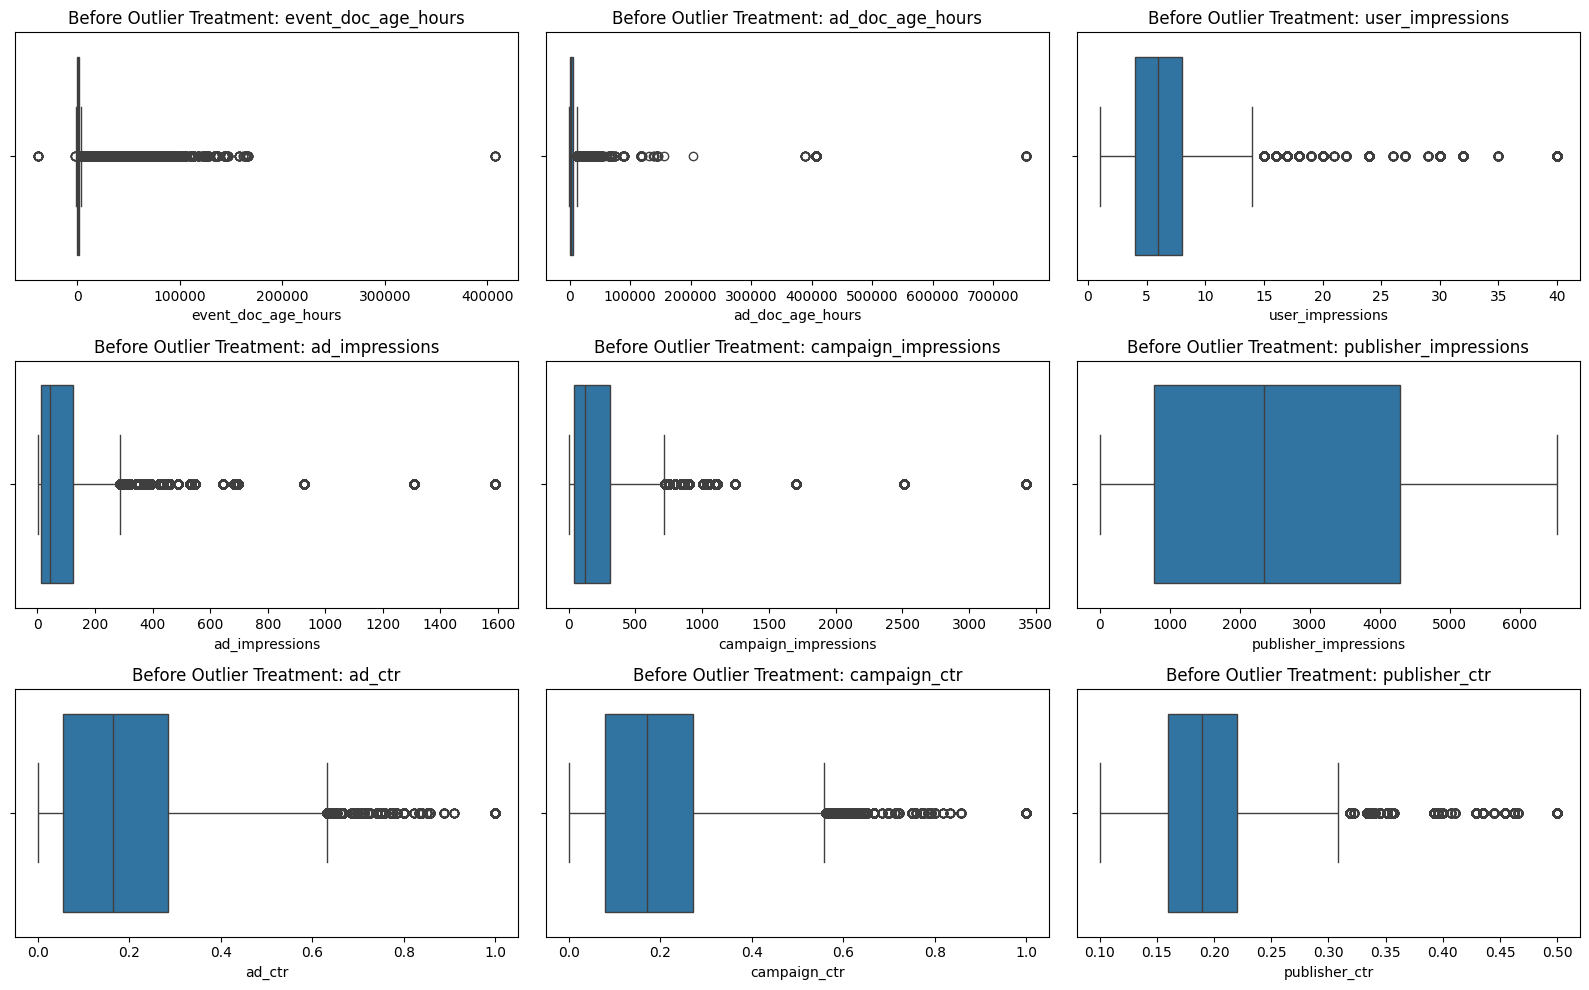

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train[col])
    plt.title(f"Before Outlier Treatment: {col}")

plt.tight_layout()
plt.show()


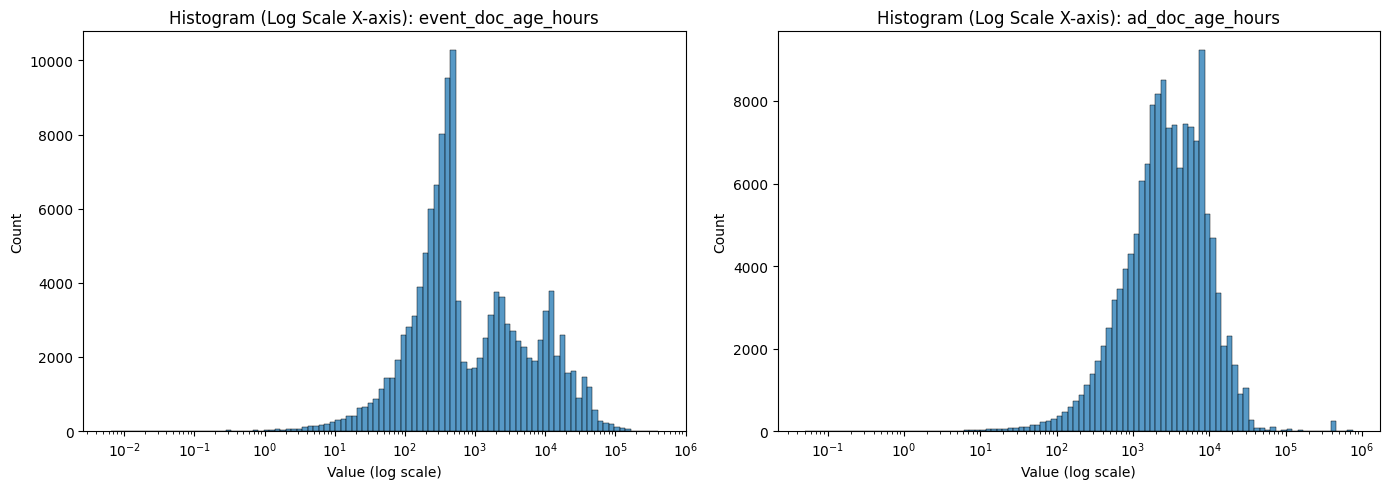

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cols = ["event_doc_age_hours", "ad_doc_age_hours"]

plt.figure(figsize=(14, 5))

for i, col in enumerate(cols, 1):
    plt.subplot(1, 2, i)
    sns.histplot(train[col].replace(0, np.nan), bins=100, log_scale=True)
    plt.title(f"Histogram (Log Scale X-axis): {col}")
    plt.xlabel("Value (log scale)")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


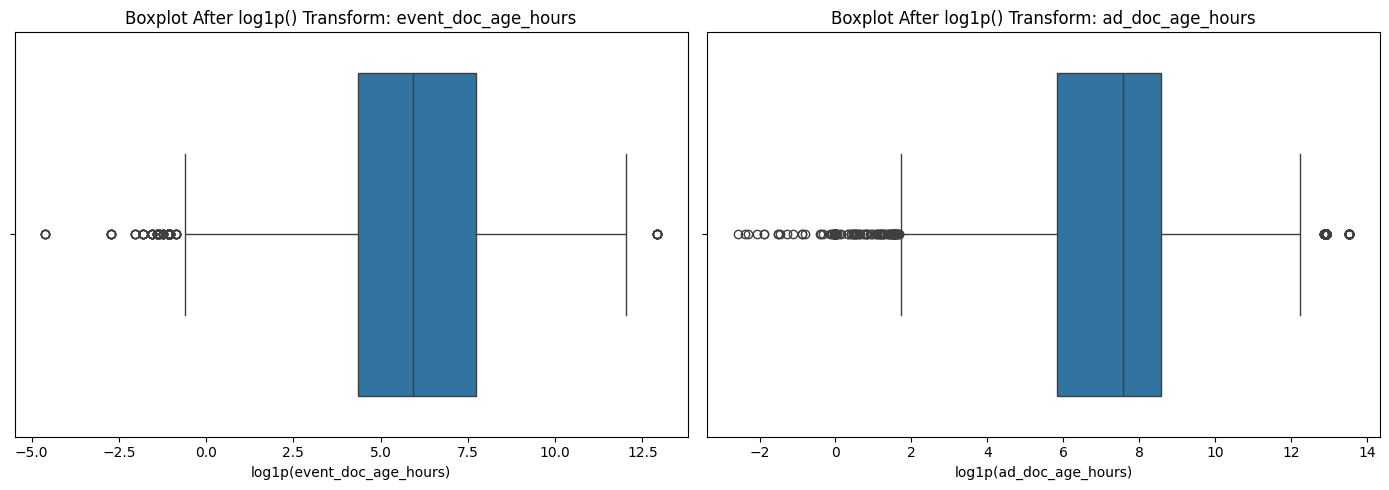

In [125]:
plt.figure(figsize=(14, 5))

for i, col in enumerate(cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=np.log1p(train[col]))
    plt.title(f"Boxplot After log1p() Transform: {col}")
    plt.xlabel(f"log1p({col})")

plt.tight_layout()
plt.show()


c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


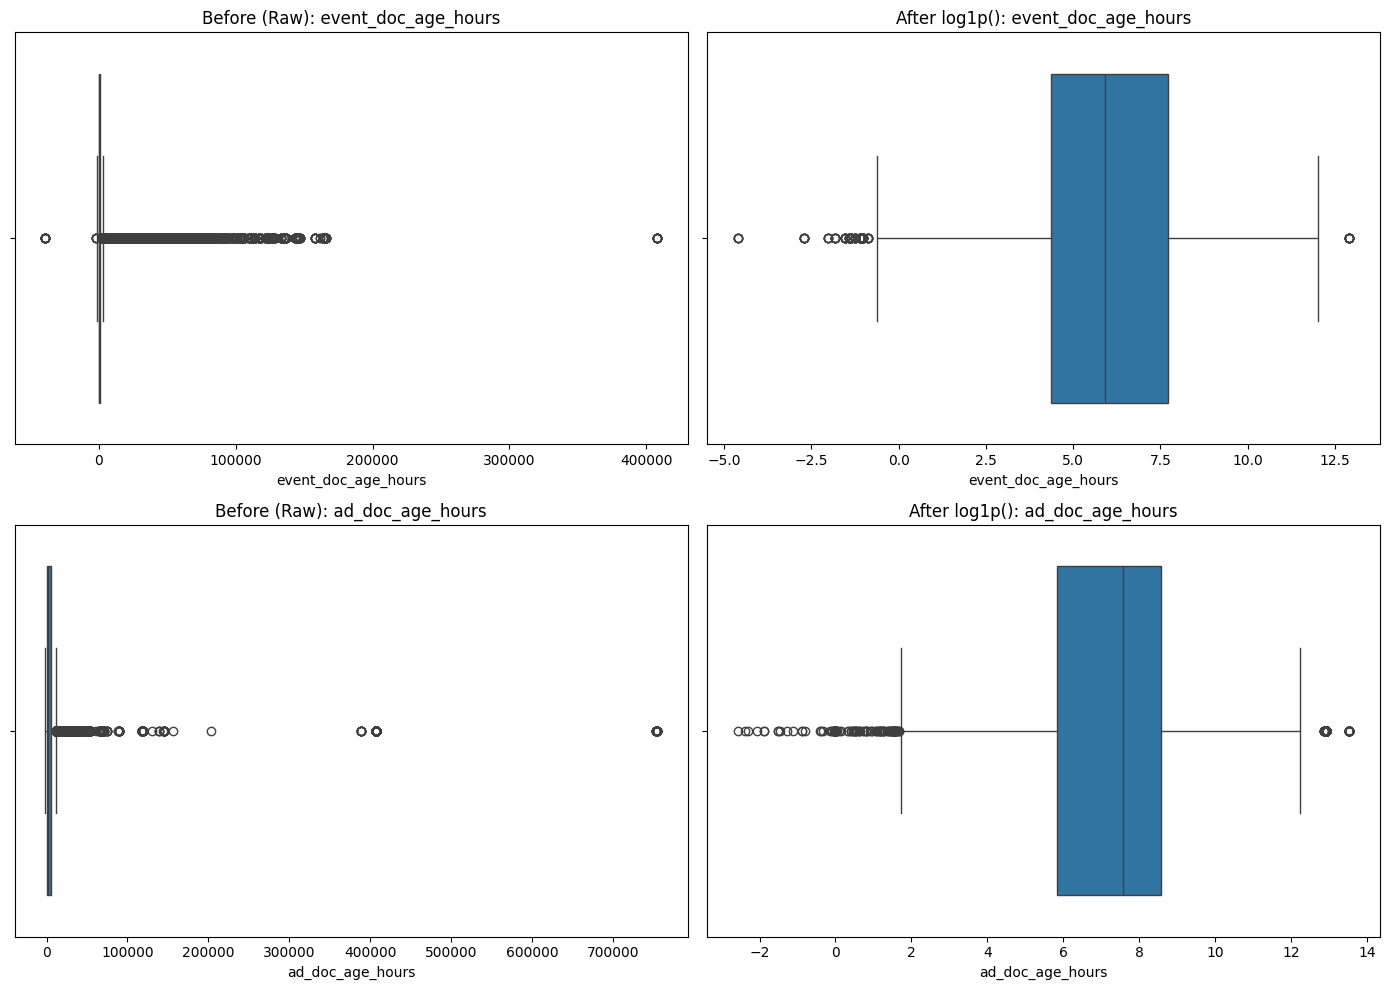

In [126]:
plt.figure(figsize=(14, 10))

for i, col in enumerate(cols):
    # before
    plt.subplot(2, 2, i*2 + 1)
    sns.boxplot(x=train[col])
    plt.title(f"Before (Raw): {col}")
    
    # after
    plt.subplot(2, 2, i*2 + 2)
    sns.boxplot(x=np.log1p(train[col]))
    plt.title(f"After log1p(): {col}")

plt.tight_layout()
plt.show()


In [127]:
print(train[numeric_cols].describe(percentiles=[0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]).T)


                          count         mean           std           min  \
event_doc_age_hours    200000.0  3029.815981   9675.346240 -38817.136389   
ad_doc_age_hours       200000.0  4129.266042  18470.126354  -1438.683611   
user_impressions       200000.0     6.279440      3.207621      1.000000   
ad_impressions         200000.0   115.036050    214.380671      1.000000   
campaign_impressions   200000.0   306.540610    562.645640      1.000000   
publisher_impressions  200000.0  2752.338370   1978.459007      2.000000   
ad_ctr                 200000.0     0.195420      0.182214      0.000000   
campaign_ctr           200000.0     0.195420      0.150782      0.000000   
publisher_ctr          200000.0     0.195420      0.059351      0.100000   

                                1%         10%         20%          50%  \
event_doc_age_hours    -303.113333 -154.634444   -9.244444   219.291111   
ad_doc_age_hours      -1270.012908    0.000000    0.000000  1623.493889   
user_impressio

In [128]:
for col in numeric_cols:
    upper = train[col].quantile(0.99)
    train[col] = train[col].clip(lower=0, upper=upper)

In [129]:
log_cols = [
    "user_impressions",
    "ad_impressions",
    "campaign_impressions",
    "publisher_impressions"
]

for col in log_cols:
    train[col] = np.log1p(train[col])


In [190]:
numeric_cols

['event_doc_age_hours',
 'ad_doc_age_hours',
 'user_impressions',
 'ad_impressions',
 'campaign_impressions',
 'publisher_impressions',
 'ad_ctr',
 'campaign_ctr',
 'publisher_ctr']

In [130]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])


In [131]:
print(train[numeric_cols].describe().T)


                          count          mean       std       min       25%  \
event_doc_age_hours    200000.0 -7.275958e-17  1.000003 -0.388000 -0.388000   
ad_doc_age_hours       200000.0 -1.364242e-17  1.000003 -0.695840 -0.695840   
user_impressions       200000.0  1.676881e-15  1.000003 -3.539290 -0.882664   
ad_impressions         200000.0 -1.176659e-16  1.000003 -1.927575 -0.721105   
campaign_impressions   200000.0  5.854872e-17  1.000003 -2.558382 -0.667662   
publisher_impressions  200000.0 -3.853984e-16  1.000003 -5.256023 -0.659227   
ad_ctr                 200000.0 -4.689582e-18  1.000003 -1.072477 -0.769986   
campaign_ctr           200000.0  3.126388e-17  1.000003 -1.335392 -0.784064   
publisher_ctr          200000.0 -1.438138e-16  1.000003 -1.645012 -0.604698   

                            50%       75%       max  
event_doc_age_hours   -0.357635 -0.215252  5.521991  
ad_doc_age_hours      -0.371733  0.267250  4.801868  
user_impressions       0.092879  0.821521  3.13

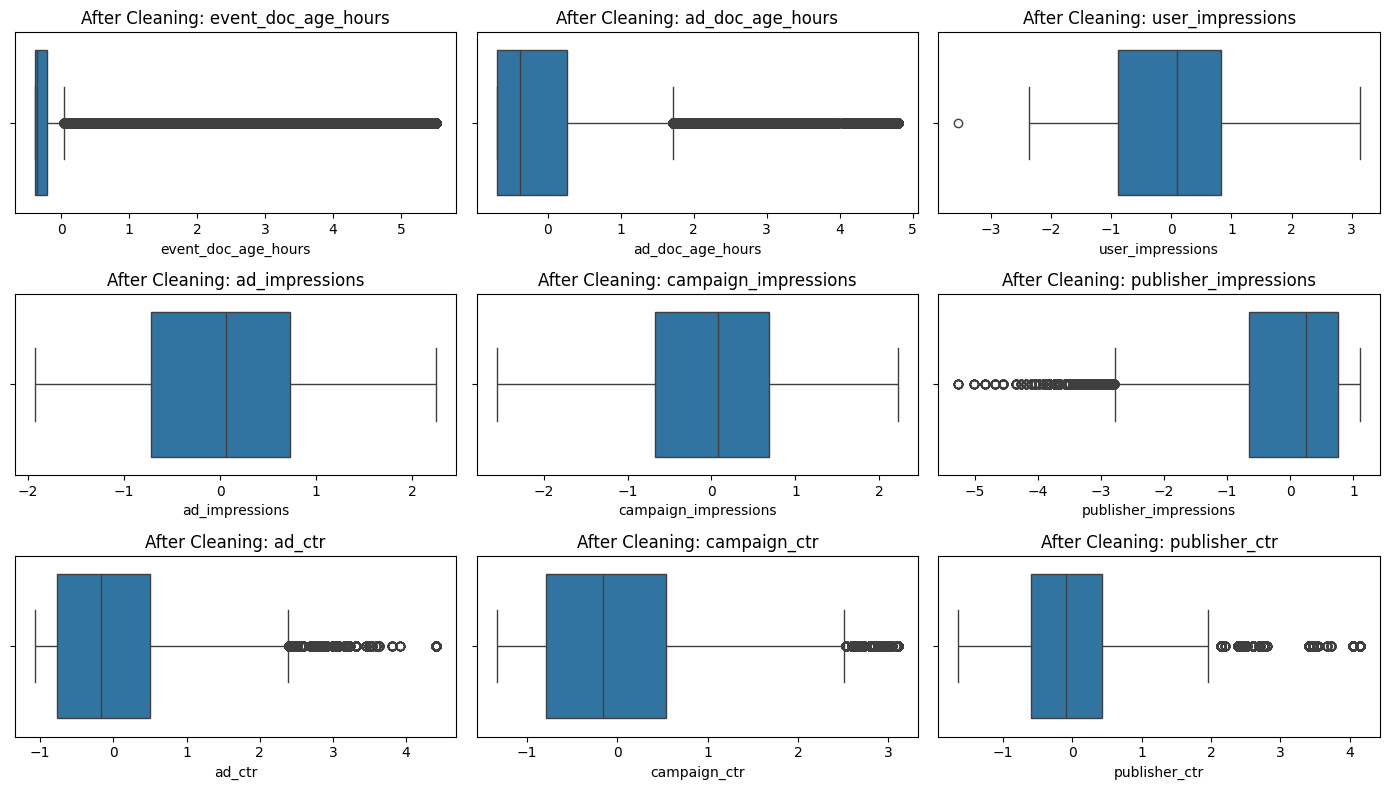

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train[col])
    plt.title(f"After Cleaning: {col}")

plt.tight_layout()
plt.show()


In [133]:
import joblib
joblib.dump(scaler, "numeric_scaler.pkl")

['numeric_scaler.pkl']

In [134]:
train.shape

(200000, 34)

In [137]:
train.head()

,ad_id,clicked,platform,country,region,dma,event_hour,campaign_id,advertiser_id,event_doc_doc_id_x,event_doc_source_id,event_doc_publisher_id,event_doc_doc_id_y,event_doc_top_topic_id,event_doc_top_topic_conf,ad_doc_doc_id_x,ad_doc_source_id,ad_doc_publisher_id,ad_doc_doc_id_y,ad_doc_top_topic_id,ad_doc_top_topic_conf,event_dayofweek,event_part_of_day,event_doc_age_hours,ad_doc_age_hours,user_impressions,ad_impressions,campaign_impressions,publisher_impressions,ad_ctr,campaign_ctr,publisher_ctr,same_topic,country_grouped
0,42337,0,3,US,SC,519,0,5969,1499,379743,6482.0,24.0,379743.0,285.0,0.020254,938164,5802.0,NaN,938164.0,142.0,0.311555,2,night,-0.388,-0.695840,0.092879,-1.219464,-1.852927,-0.276569,0.025135,0.040935,0.32938,0,US
1,139684,0,3,US,SC,519,0,17527,2563,379743,6482.0,24.0,379743.0,285.0,0.020254,1085937,10727.0,NaN,1085937.0,231.0,0.363159,2,night,-0.388,-0.157420,0.092879,-1.219464,-1.223105,-0.276569,-1.072477,-1.335392,0.32938,0,US
2,144739,1,3,US,SC,519,0,18488,2909,379743,6482.0,24.0,379743.0,285.0,0.020254,1337362,11328.0,NaN,1337362.0,131.0,0.272269,2,night,-0.388,-0.515366,0.092879,1.053450,0.825933,-0.276569,0.576645,0.633324,0.32938,0,US
3,156824,0,3,US,SC,519,0,7283,1919,379743,6482.0,24.0,379743.0,285.0,0.020254,992370,8064.0,NaN,992370.0,138.0,0.318320,2,night,-0.388,0.803824,0.092879,0.969185,1.572417,-0.276569,-0.794991,-1.136085,0.32938,0,US
4,279295,0,3,US,SC,519,0,27524,1820,379743,6482.0,24.0,379743.0,285.0,0.020254,1670176,8239.0,NaN,1670176.0,16.0,0.045296,2,night,-0.388,-0.695840,0.092879,-0.673339,-1.184176,-0.276569,0.193999,0.385017,0.32938,0,US


In [136]:
train.isna().mean() * 100

ad_id                        0.0000
clicked                      0.0000
platform                     0.0000
country                      0.0000
region                       0.0000
dma                          0.0000
event_hour                   0.0000
campaign_id                  0.0000
advertiser_id                0.0000
event_doc_doc_id_x           0.0000
event_doc_source_id          0.0000
event_doc_publisher_id       0.0000
event_doc_doc_id_y           3.1205
event_doc_top_topic_id       3.1205
event_doc_top_topic_conf     3.1205
ad_doc_doc_id_x              0.0000
ad_doc_source_id             0.0040
ad_doc_publisher_id         66.0465
ad_doc_doc_id_y              0.2830
ad_doc_top_topic_id          0.2830
ad_doc_top_topic_conf        0.2830
event_dayofweek              0.0000
event_part_of_day            0.0000
event_doc_age_hours          0.0000
ad_doc_age_hours             0.0000
user_impressions             0.0000
ad_impressions               0.0000
campaign_impressions        

In [141]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
import pandas as pd

# all input features
feature_cols = categorical_cols + numeric_cols

X = train[feature_cols].copy()
y = train["clicked"].astype(int)

# LightGBM likes categoricals as 'category' dtype
for col in categorical_cols:
    if col in X.columns:
        X[col] = X[col].astype("category")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [148]:
from lightgbm import LGBMClassifier

# class imbalance weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = LGBMClassifier(
    objective="binary",
    learning_rate=0.05,
    num_leaves=64,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=50,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(100),      # replaces early_stopping_rounds
        lgb.log_evaluation(50),      # prints every 50 iters
    ],
)

# metrics
y_val_pred = model.predict_proba(X_val)[:, 1]
print("Val AUC:", roc_auc_score(y_val, y_val_pred))
print("Val logloss:", log_loss(y_val, y_val_pred))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 31267, number of negative: 128733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20068
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195419 -> initscore=-1.415177
[LightGBM] [Info] Start training from score -1.415177
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.862372	training's binary_logloss: 0.453902	valid_1's auc: 0.806281	valid_1's binary_logloss: 0.491965
[100]	training's auc: 0.886984	training's binary_logloss: 0.43924	valid_1's auc: 0.79

In [149]:
gain_importance = model.booster_.feature_importance(importance_type="gain")
split_importance = model.booster_.feature_importance(importance_type="split")

importances = pd.DataFrame({
    "feature": feature_cols,
    "gain": gain_importance,
    "split": split_importance,
}).sort_values("gain", ascending=False)

importances.head(25)


,feature,gain,split
20,ad_ctr,469639.040794,94
21,campaign_ctr,93749.918701,19
16,user_impressions,29688.056587,64
8,event_doc_source_id,23506.009712,134
4,ad_id,13725.955414,95
7,event_doc_publisher_id,7824.103989,51
5,campaign_id,5928.860237,40
3,dma,5228.422104,41
10,ad_doc_source_id,4744.305046,36
11,event_doc_top_topic_id,4288.937874,36


In [150]:
used_feats = importances[importances["gain"] > 0]["feature"].tolist()

FINAL_FEATURES = used_feats
FINAL_CATEGORICAL = [c for c in FINAL_FEATURES if c in categorical_cols]
FINAL_NUMERIC = [c for c in FINAL_FEATURES if c in numeric_cols]


In [152]:
import numpy as np

cat_vocab = {}        # {col_name: {value: idx}}
cat_num_classes = {}  # {col_name: num_categories_including_UNK}

for col in FINAL_CATEGORICAL:
    # get uniques (dropna, convert to str just in case)
    uniques = train[col].astype(str).fillna("UNK").unique()
    
    # start from 1; 0 is reserved for UNK
    vocab = {val: i+1 for i, val in enumerate(uniques)}
    vocab["<UNK>"] = 0
    
    cat_vocab[col] = vocab
    cat_num_classes[col] = len(vocab)

cat_num_classes


{'event_doc_source_id': 1528,
 'ad_id': 22495,
 'event_doc_publisher_id': 376,
 'campaign_id': 8499,
 'dma': 212,
 'ad_doc_source_id': 2429,
 'event_doc_top_topic_id': 294,
 'advertiser_id': 1756,
 'region': 277,
 'ad_doc_top_topic_id': 300}

In [153]:
import joblib
joblib.dump(cat_vocab, "cat_vocab.pkl")
joblib.dump(cat_num_classes, "cat_num_classes.pkl")


['cat_num_classes.pkl']

In [154]:
for col in FINAL_CATEGORICAL:
    vocab = cat_vocab[col]
    train[col + "_idx"] = (
        train[col].astype(str)
             .fillna("UNK")
             .map(vocab)
             .fillna(0)
             .astype("int64")
    )


In [156]:
from sklearn.model_selection import train_test_split

# all feature columns that will go into PyTorch
all_feature_cols_for_torch = (
    [c + "_idx" for c in FINAL_CATEGORICAL] + FINAL_NUMERIC
)

# 1) build one DataFrame with features + label
df_all = train[all_feature_cols_for_torch + ["clicked"]].reset_index(drop=True)

# 2) split into train/val
train_df, val_df = train_test_split(
    df_all,
    test_size=0.2,
    stratify=df_all["clicked"],
    random_state=42
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


In [159]:
import torch
from torch.utils.data import Dataset, DataLoader

class CTRDataset(Dataset):
    def __init__(self, df, cat_cols, num_cols, target_col="clicked"):
        self.df = df
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.target_col = target_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # categorical as long tensors
        cat_vals = torch.tensor(
            row[self.cat_cols].values.astype("int64"),
            dtype=torch.long
        )

        # numeric as float tensors
        num_vals = torch.tensor(
            row[self.num_cols].values.astype("float32"),
            dtype=torch.float
        )

        # label
        y = torch.tensor(
            row[self.target_col],
            dtype=torch.float32
        )

        return cat_vals, num_vals, y

In [160]:
cat_idx_cols = [c + "_idx" for c in FINAL_CATEGORICAL]
num_cols = FINAL_NUMERIC

In [161]:
train_dataset = CTRDataset(train_df, cat_idx_cols, num_cols, target_col="clicked")
val_dataset   = CTRDataset(val_df,   cat_idx_cols, num_cols, target_col="clicked")

In [162]:
BATCH_SIZE = 1024  # you can tune this

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # increase if your machine supports
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

In [163]:
batch = next(iter(train_loader))
cat_batch, num_batch, y_batch = batch

print(cat_batch.shape)  # [batch_size, num_cat_features]
print(num_batch.shape)  # [batch_size, num_numeric_features]
print(y_batch.shape)    # [batch_size]

torch.Size([1024, 10])
torch.Size([1024, 5])
torch.Size([1024])


In [176]:
# hyper param tuning
import numpy as np
import optuna

SUB_FRACTION = 0.25   # 25% of train_df for tuning

tune_df = train_df.sample(frac=SUB_FRACTION, random_state=123).reset_index(drop=True)

from sklearn.model_selection import train_test_split

tune_train_df, tune_val_df = train_test_split(
    tune_df,
    test_size=0.2,
    stratify=tune_df["clicked"],
    random_state=123,
)

tune_train_df = tune_train_df.reset_index(drop=True)
tune_val_df   = tune_val_df.reset_index(drop=True)

# build datasets/loaders for tuning
tune_train_dataset = CTRDataset(tune_train_df, cat_idx_cols, num_cols, "clicked")
tune_val_dataset   = CTRDataset(tune_val_df,   cat_idx_cols, num_cols, "clicked")

tune_train_loader = DataLoader(tune_train_dataset, batch_size=1024, shuffle=True)
tune_val_loader   = DataLoader(tune_val_dataset,   batch_size=1024, shuffle=False)


c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [164]:
import torch
import torch.nn as nn

def get_emb_dim(n_cat):
    return min(50, int(round(n_cat ** 0.5) * 2))


In [ ]:
class CTRModel(nn.Module):
    def __init__(self, cat_num_classes, num_numeric_features, emb_dropout=0.1, hidden_dims=(128, 64)):
        super().__init__()
        self.cat_cols = list(cat_num_classes.keys())

        # Embedding layers per categorical feature
        self.emb_layers = nn.ModuleDict()
        emb_output_dims = []
        for col, n_classes in cat_num_classes.items():
            emb_dim = get_emb_dim(n_classes)
            self.emb_layers[col] = nn.Embedding(
                num_embeddings=n_classes,
                embedding_dim=emb_dim,
                padding_idx=0  # our UNK index
            )
            emb_output_dims.append(emb_dim)

        total_emb_dim = sum(emb_output_dims)
        self.num_numeric_features = num_numeric_features

        input_dim = total_emb_dim + num_numeric_features

        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(emb_dropout))
            prev_dim = h

        self.mlp = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, cat_inputs, num_inputs):
        """
        cat_inputs: [batch_size, num_cat_features] (indices)
        num_inputs: [batch_size, num_numeric_features]
        """
        emb_list = []
        # cat_inputs columns must be in the same order as self.cat_cols
        for i, col in enumerate(self.cat_cols):
            emb = self.emb_layers[col](cat_inputs[:, i])
            emb_list.append(emb)

        emb_concat = torch.cat(emb_list, dim=1)   # [B, sum_emb_dims]
        x = torch.cat([emb_concat, num_inputs], dim=1)

        x = self.mlp(x)
        logits = self.output_layer(x).squeeze(1)  # [B]
        return logits   # use with BCEWithLogitsLoss


In [174]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for cat_batch, num_batch, y_batch in loader:
        cat_batch = cat_batch.to(device)
        num_batch = num_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(cat_batch, num_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y_batch.size(0)

    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for cat_batch, num_batch, y_batch in loader:
        cat_batch = cat_batch.to(device)
        num_batch = num_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(cat_batch, num_batch)
        loss = criterion(logits, y_batch)

        total_loss += loss.item() * y_batch.size(0)
        probs = torch.sigmoid(logits)
        all_preds.append(probs.cpu())
        all_labels.append(y_batch.cpu())

    preds = torch.cat(all_preds).numpy()
    labels = torch.cat(all_labels).numpy()

    auc = roc_auc_score(labels, preds)
    ll = log_loss(labels, preds)

    return total_loss / len(loader.dataset), auc, ll


In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cat_num_classes_final = {col: cat_num_classes[col] for col in FINAL_CATEGORICAL}
num_numeric_features = len(FINAL_NUMERIC)

def objective(trial: optuna.Trial):
    # ---- hyperparams to search ----
    lr = trial.suggest_float("lr", 5e-4, 2e-3, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.4)
    hidden = trial.suggest_categorical("hidden", [(128, 64), (256, 128), (256, 128, 64)])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    pos_weight_scale = trial.suggest_float("pos_weight_scale", 0.4, 1.2)

    # ---- model ----
    model = CTRModel(
        cat_num_classes=cat_num_classes_final,
        num_numeric_features=num_numeric_features,
        emb_dropout=dropout,
        hidden_dims=hidden,
    ).to(device)

    # imbalance handling on tuning train split
    pos = (tune_train_df["clicked"] == 1).sum()
    neg = (tune_train_df["clicked"] == 0).sum()
    base_pos_weight = neg / pos
    pos_weight = torch.tensor(
        [base_pos_weight * pos_weight_scale],
        dtype=torch.float32,
        device=device,
    )

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    EPOCHS_TUNE = 3  # small, just for ranking configs

    best_val_logloss = float("inf")

    for epoch in range(EPOCHS_TUNE):
        train_one_epoch(model, tune_train_loader, optimizer, criterion, device)
        val_loss, val_auc, val_logloss = eval_epoch(model, tune_val_loader, criterion, device)

        # report to Optuna (so it can prune bad trials)
        trial.report(val_logloss, epoch)

        # optional pruning
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_logloss < best_val_logloss:
            best_val_logloss = val_logloss

    return best_val_logloss  # Optuna will minimize this


In [179]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, show_progress_bar=True)

print("Best trial:")
print("  value (val_logloss):", study.best_value)
print("  params:", study.best_params)


[I 2025-11-29 15:43:55,111] A new study created in memory with name: no-name-1895361c-f235-4b7c-83bf-5169ad967806
  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 

[I 2025-11-29 15:44:35,140] Trial 0 finished with value: 0.5368926805487569 and parameters: {'lr': 0.0015231998091343186, 'dropout': 0.33364045487648, 'hidden': (256, 128), 'weight_decay': 1.695691671104764e-05, 'pos_weight_scale': 0.9444404580153816}. Best is trial 0 with value: 0.5368926805487569.


Best trial: 0. Best value: 0.536893:  20%|██        | 2/10 [01:20<05:20, 40.11s/it]c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)


[I 2025-11-29 15:45:15,309] Trial 1 finished with value: 0.5413588708601306 and parameters: {'lr': 0.0011737396532408993, 'dropout': 0.13307516488257348, 'hidden': (256, 128), 'weight_decay': 5.634269592563743e-06, 'pos_weight_scale': 0.9174345954176851}. Best is trial 0 with value: 0.5368926805487569.


Best trial: 2. Best value: 0.485569:  30%|███       | 3/10 [02:00<04:42, 40.38s/it]c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)


[I 2025-11-29 15:45:56,022] Trial 2 finished with value: 0.48556877303079854 and parameters: {'lr': 0.0016959186477672847, 'dropout': 0.25872162175508506, 'hidden': (256, 128), 'weight_decay': 5.090216172978831e-05, 'pos_weight_scale': 0.7087017828878547}. Best is trial 2 with value: 0.48556877303079854.


Best trial: 3. Best value: 0.460836:  40%|████      | 4/10 [02:41<04:03, 40.55s/it]c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)


[I 2025-11-29 15:46:36,840] Trial 3 finished with value: 0.46083589764629523 and parameters: {'lr': 0.0007717194459653799, 'dropout': 0.21700091056049384, 'hidden': (256, 128, 64), 'weight_decay': 3.201759837634279e-05, 'pos_weight_scale': 0.541135921428156}. Best is trial 3 with value: 0.46083589764629523.


Best trial: 4. Best value: 0.4447:  50%|█████     | 5/10 [03:22<03:22, 40.49s/it]  c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)


[I 2025-11-29 15:47:17,223] Trial 4 finished with value: 0.4447002927364989 and parameters: {'lr': 0.0014297966593943819, 'dropout': 0.17439646346798368, 'hidden': (256, 128), 'weight_decay': 1.782520988204242e-05, 'pos_weight_scale': 0.5198850450962202}. Best is trial 4 with value: 0.4447002927364989.


Best trial: 4. Best value: 0.4447:  60%|██████    | 6/10 [03:35<02:05, 31.35s/it]c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)


[I 2025-11-29 15:47:30,834] Trial 5 pruned. 


Best trial: 4. Best value: 0.4447:  70%|███████   | 7/10 [03:49<01:16, 25.56s/it]c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)


[I 2025-11-29 15:47:44,476] Trial 6 pruned. 


Best trial: 4. Best value: 0.4447:  80%|████████  | 8/10 [04:30<01:00, 30.49s/it]c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)


[I 2025-11-29 15:48:25,512] Trial 7 finished with value: 0.44625120259709433 and parameters: {'lr': 0.0014792976507357455, 'dropout': 0.11044174862183515, 'hidden': (256, 128, 64), 'weight_decay': 8.033659931979691e-05, 'pos_weight_scale': 0.5386220054441317}. Best is trial 4 with value: 0.4447002927364989.


Best trial: 4. Best value: 0.4447:  90%|█████████ | 9/10 [04:43<00:25, 25.15s/it]c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)


[I 2025-11-29 15:48:38,911] Trial 8 pruned. 


Best trial: 4. Best value: 0.4447: 100%|██████████| 10/10 [04:57<00:00, 29.75s/it]

[I 2025-11-29 15:48:52,621] Trial 9 pruned. 
Best trial:
  value (val_logloss): 0.4447002927364989
  params: {'lr': 0.0014297966593943819, 'dropout': 0.17439646346798368, 'hidden': (256, 128), 'weight_decay': 1.782520988204242e-05, 'pos_weight_scale': 0.5198850450962202}


In [180]:
# restrict cat_num_classes to final categoricals only, and in a fixed order
cat_num_classes_final = {col: cat_num_classes[col] for col in FINAL_CATEGORICAL}

num_numeric_features = len(FINAL_NUMERIC)

final_model = CTRModel(
    cat_num_classes=cat_num_classes_final,
    num_numeric_features=num_numeric_features,
    emb_dropout=study.best_params["dropout"],
    hidden_dims=study.best_params["hidden"],
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model.to(device)

print(final_model)


CTRModel(
  (emb_layers): ModuleDict(
    (event_doc_source_id): Embedding(1528, 50, padding_idx=0)
    (ad_id): Embedding(22495, 50, padding_idx=0)
    (event_doc_publisher_id): Embedding(376, 38, padding_idx=0)
    (campaign_id): Embedding(8499, 50, padding_idx=0)
    (dma): Embedding(212, 30, padding_idx=0)
    (ad_doc_source_id): Embedding(2429, 50, padding_idx=0)
    (event_doc_top_topic_id): Embedding(294, 34, padding_idx=0)
    (advertiser_id): Embedding(1756, 50, padding_idx=0)
    (region): Embedding(277, 34, padding_idx=0)
    (ad_doc_top_topic_id): Embedding(300, 34, padding_idx=0)
  )
  (mlp): Sequential(
    (0): Linear(in_features=425, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.17439646346798368, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.17439646346798368, inplace=False)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)


In [181]:
pos = (train_df["clicked"] == 1).sum()
neg = (train_df["clicked"] == 0).sum()
base_pos_weight = neg / pos

pos_weight = torch.tensor(
    [base_pos_weight * study.best_params["pos_weight_scale"]],
    dtype=torch.float32,
    device=device,
)

criterion_final = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

In [182]:
optimizer_final = torch.optim.Adam(
    final_model.parameters(),
    lr=study.best_params["lr"],
    weight_decay=study.best_params["weight_decay"],
)

In [184]:
EPOCHS_FULL = 5
best_val_logloss = float("inf")
patience = 3
no_improve = 0

for epoch in range(1, EPOCHS_FULL + 1):
    train_loss = train_one_epoch(final_model, train_loader, optimizer_final, criterion_final, device)
    val_loss, val_auc, val_logloss = eval_epoch(final_model, val_loader, criterion_final, device)

    print(
        f"Epoch {epoch}: "
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_auc={val_auc:.4f} | "
        f"val_logloss={val_logloss:.4f}"
    )

    if val_logloss < best_val_logloss - 1e-4:
        best_val_logloss = val_logloss
        no_improve = 0
        # optional: keep a checkpoint of the best model
        best_state_dict = {k: v.cpu().clone() for k, v in final_model.state_dict().items()}
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break

# restore best checkpoint (optional but recommended)
final_model.load_state_dict(best_state_dict)
final_model.to(device)


Epoch 1: train_loss=0.6456 | val_loss=0.6164 | val_auc=0.8005 | val_logloss=0.4337
Epoch 2: train_loss=0.6027 | val_loss=0.6089 | val_auc=0.8047 | val_logloss=0.4349
Epoch 3: train_loss=0.5878 | val_loss=0.6072 | val_auc=0.8054 | val_logloss=0.4353
Epoch 4: train_loss=0.5752 | val_loss=0.6100 | val_auc=0.8040 | val_logloss=0.4260
Epoch 5: train_loss=0.5646 | val_loss=0.6129 | val_auc=0.8013 | val_logloss=0.4325


CTRModel(
  (emb_layers): ModuleDict(
    (event_doc_source_id): Embedding(1528, 50, padding_idx=0)
    (ad_id): Embedding(22495, 50, padding_idx=0)
    (event_doc_publisher_id): Embedding(376, 38, padding_idx=0)
    (campaign_id): Embedding(8499, 50, padding_idx=0)
    (dma): Embedding(212, 30, padding_idx=0)
    (ad_doc_source_id): Embedding(2429, 50, padding_idx=0)
    (event_doc_top_topic_id): Embedding(294, 34, padding_idx=0)
    (advertiser_id): Embedding(1756, 50, padding_idx=0)
    (region): Embedding(277, 34, padding_idx=0)
    (ad_doc_top_topic_id): Embedding(300, 34, padding_idx=0)
  )
  (mlp): Sequential(
    (0): Linear(in_features=425, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.17439646346798368, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.17439646346798368, inplace=False)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

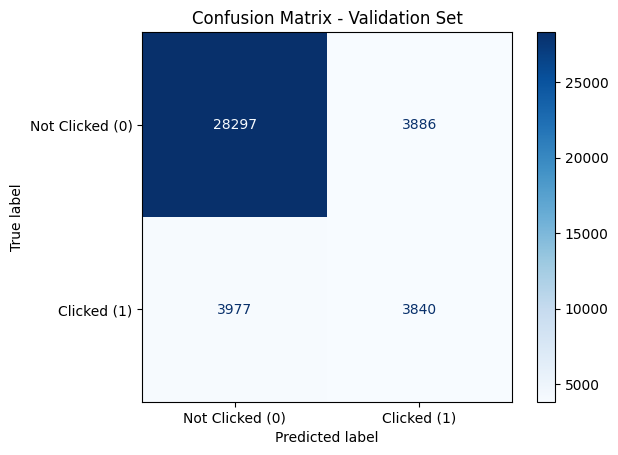

In [185]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

@torch.no_grad()
def compute_confusion_matrix(model, loader, device):
    model.eval()
    
    all_preds = []
    all_labels = []

    for cat_batch, num_batch, y_batch in loader:
        cat_batch = cat_batch.to(device)
        num_batch = num_batch.to(device)

        logits = model(cat_batch, num_batch)
        probs = torch.sigmoid(logits)

        preds = (probs > 0.5).long().cpu().numpy()
        labels = y_batch.long().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    # build confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

# ---- compute on your validation set ----
cm = compute_confusion_matrix(final_model, val_loader, device)

# ---- visualize ----
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Clicked (0)", "Clicked (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Validation Set")
plt.show()


In [188]:
import torch, joblib

torch.save(final_model.state_dict(), "ctr_model.pth")
joblib.dump(cat_vocab, "cat_vocab.pkl")          # dict[col][value] -> idx
joblib.dump(cat_num_classes, "cat_num_classes.pkl")
joblib.dump(scaler, "numeric_scaler.pkl")        # from StandardScaler on numeric_cols
joblib.dump(FINAL_CATEGORICAL, "final_categorical.pkl")
joblib.dump(FINAL_NUMERIC, "final_numeric.pkl")


['final_numeric.pkl']

In [191]:
FINAL_NUMERIC

['ad_ctr',
 'campaign_ctr',
 'user_impressions',
 'publisher_ctr',
 'publisher_impressions']

In [198]:
df = pd.read_csv('data/train_merged.csv')
raw = df.sample(1).iloc[0]
pd.Series(raw, index=df.columns).to_dict()

{'display_id': 20894,
 'ad_id': 308610,
 'clicked': 0,
 'uuid': '2200ad4eb46687',
 'event_doc_id': 1118196,
 'event_timestamp': 1484531,
 'platform': 1,
 'country': 'US',
 'region': 'CT',
 'dma': 501.0,
 'event_hour': 412,
 'ad_doc_id': 1712989,
 'campaign_id': 2668,
 'advertiser_id': 580,
 'event_doc_doc_id_x': 1118196,
 'event_doc_source_id': 9135.0,
 'event_doc_publisher_id': 1042.0,
 'event_doc_publish_time': '2016-02-26 12:00:00',
 'event_doc_doc_id_y': 1118196.0,
 'event_doc_top_topic_id': 130.0,
 'event_doc_top_topic_conf': 0.0504428600643973,
 'ad_doc_doc_id_x': 1712989,
 'ad_doc_source_id': 4686.0,
 'ad_doc_publisher_id': 503.0,
 'ad_doc_publish_time': '2016-06-10 00:00:00',
 'ad_doc_doc_id_y': 1712989.0,
 'ad_doc_top_topic_id': 140.0,
 'ad_doc_top_topic_conf': 0.466515923812271}